In [37]:
#
#
#
#
#
#
#
#
#
#    in questa versione alleno 1 rete su tutte le batterie!!!
#
#
#
#
#
#

#
#


In [38]:
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import math


import torch
import torch.nn as nn
from torch.autograd import Variable
from scipy.integrate import odeint

from numpy import diff, gradient
from scipy.ndimage import gaussian_filter1d , gaussian_filter


#importo il database
oxford_dataset = scipy.io.loadmat('dataset/Oxford/Oxford_Battery_Degradation_Dataset_1.mat', simplify_cells=True)

#elimino le parti non interessanti
del oxford_dataset["__header__"]
del oxford_dataset["__version__"]
del oxford_dataset["__globals__"]




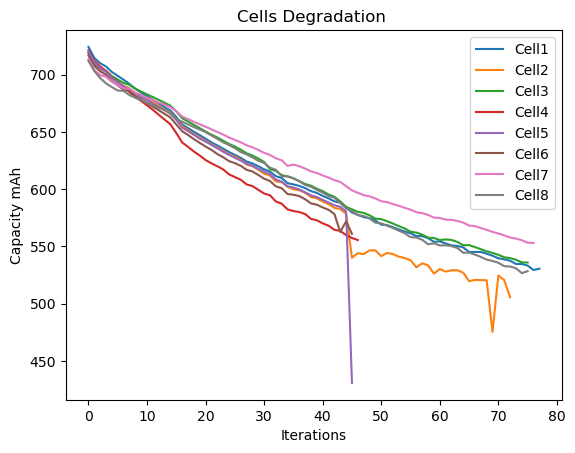

In [39]:
#Plot Capacity Degradation
#Get the maximum value of the Capacity(mAH) for every charge


# n iteration - 100 cicli al max nel DB
x=np.arange(100) 

# dizionario con la carica raggiunta, da ogni batteria, a ogni fine ciclo di ricearica
capacity={}          
for ox_key, ox_value in oxford_dataset.items():
    capacity[ox_key] = []
    for value in ox_value:
        last = ox_value[value]['C1ch']['q'].shape[0] - 1
        capacity[ox_key].append(ox_value[value]['C1ch']['q'][last])


# stampo i livelli di ricarica per ogni batteria, per i vari cilci 
fig, ax = plt.subplots()
# ax.plot(x[ : len(capacity['Cell1'])], capacity['Cell1'], label="Cell1" ) per ogni cella
for cell in capacity:
    ax.plot(x[ : len(capacity[cell])], capacity[cell], label=cell )


ax.set(title="Cells Degradation ", xlabel="Iterations", ylabel="Capacity mAh")
ax.legend()

plt.show()

In [40]:
v_ch = oxford_dataset['Cell1']['cyc0000']['C1ch']['v']  # andamento V base per plottare
v_ch0000 = oxford_dataset['Cell1']['cyc0000']['C1ch']['v']  # andamento V base per plottare
v_ch0400 = oxford_dataset['Cell1']['cyc0400']['C1ch']['v']  # andamento V base per plottare
v_ch0800 = oxford_dataset['Cell1']['cyc0800']['C1ch']['v']  # andamento V base per plottare
v_ch1200 = oxford_dataset['Cell1']['cyc1200']['C1ch']['v']  # andamento V base per plottare
v_ch2000 = oxford_dataset['Cell1']['cyc2000']['C1ch']['v']  # andamento V base per plottare
v_ch3000 = oxford_dataset['Cell1']['cyc3000']['C1ch']['v']  # andamento V base per plottare
v_ch5000 = oxford_dataset['Cell1']['cyc5000']['C1ch']['v']  # andamento V base per plottare
v_ch7000 = oxford_dataset['Cell1']['cyc7000']['C1ch']['v']  # andamento V base per plottare


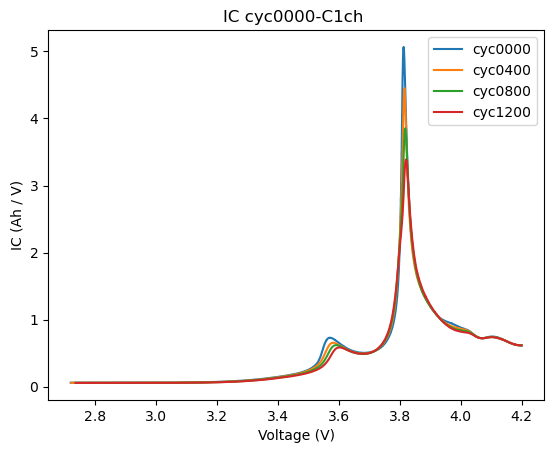

In [41]:
# plot incremental capacity IC = ∆Q / ∆V respect the volts changing
# The change of IC curves with the deterioration of the battery.


ics={}
for id_battery, value_battery in oxford_dataset.items():
    ics[id_battery]={}
    for id_cycle, value_cycle in value_battery.items():
        
        q = gaussian_filter1d(oxford_dataset[id_battery][id_cycle]['C1ch']['q'],50)
        v = gaussian_filter1d(oxford_dataset[id_battery][id_cycle]['C1ch']['v'],50)
        ics[id_battery][id_cycle] = diff(q/1000) /diff(v) 


fig, ax = plt.subplots()
ax.plot(v_ch[ : len(ics['Cell1']['cyc0000'])], ics['Cell1']['cyc0000'], label="cyc0000" )
ax.plot(v_ch0400[ : len(ics['Cell1']['cyc0400'])], ics['Cell1']['cyc0400'], label="cyc0400" )
ax.plot(v_ch0800[ : len(ics['Cell1']['cyc0800'])], ics['Cell1']['cyc0800'], label="cyc0800" )
ax.plot(v_ch1200[ : len(ics['Cell1']['cyc1200'])], ics['Cell1']['cyc1200'], label="cyc1200" )

ax.set(title="IC cyc0000-C1ch ", xlabel="Voltage (V)", ylabel="IC (Ah / V)")
ax.legend()

plt.show()

In [42]:
def diff_method(a,L=40):
    dm=[]
    for k in range(a.size-L):
        dm.append(( a[k+L] - a[k]) / L)
    return dm

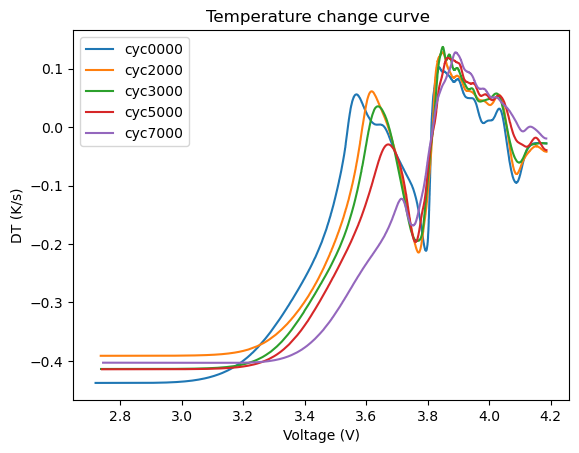

In [51]:
# plot Temperature change acquisition
# to mitigate the impact of the noise, it is used the differential method con L=40
# DT(k) = T(k + L) - T(k)  / L 

DTs={}
for id_battery, value_battery in oxford_dataset.items():
    DTs[id_battery]={}
    for id_cycle, value_cycle in value_battery.items():
        
        T = oxford_dataset[id_battery][id_cycle]['C1ch']['T']*100
        DTs[id_battery][id_cycle] = gaussian_filter(diff_method(T),50)

fig, ax = plt.subplots()
ax.plot(v_ch[ : len(DTs['Cell1']['cyc0000'])], DTs['Cell1']['cyc0000'], label="cyc0000" )
ax.plot(v_ch2000[ : len(DTs['Cell1']['cyc2000'])], DTs['Cell1']['cyc2000'], label="cyc2000" )
ax.plot(v_ch3000[ : len(DTs['Cell1']['cyc3000'])], DTs['Cell1']['cyc3000'], label="cyc3000" )
ax.plot(v_ch5000[ : len(DTs['Cell1']['cyc5000'])], DTs['Cell1']['cyc5000'], label="cyc5000" )
ax.plot(v_ch7000[ : len(DTs['Cell1']['cyc7000'])], DTs['Cell1']['cyc7000'], label="cyc7000" )

ax.set(title="Temperature change curve ", xlabel="Voltage (V)", ylabel="DT (K/s)")
ax.legend()

plt.show()

In [44]:
 #Features extractions
 # X = [P-IC, left peak, mid valley, voltage-difference]
 # y = SoH = Qmax/Qk

#Extraction of y from capacity
y={}

for id_battery, values_battery in capacity.items():
    y[id_battery]=[]
    for key, value in enumerate(values_battery):
        y[id_battery].append(  capacity[id_battery][key] / capacity[id_battery][0] ) 


#Extraction of P-IC  from ICs
pics = {}
for id_battery, values_battery in ics.items():
    pics[id_battery]=[]
    for id_cycle, values_cycle in values_battery.items():
        pics[id_battery].append( max(values_cycle)   )


#Extraction of left-peak, mid_valley and volt-diff fro DTs
# left peak -> primo massimo a partire da v= 3.4
# mid Valley -> primo minimo a partire da left peak
# volt diff -> differenza dei valori di volt
left_peaks = {}
mid_valleys = {}
volt_diffs = {}
for id_battery, values_battery in DTs.items():
    left_peaks[id_battery] = []
    mid_valleys[id_battery] = []
    volt_diffs[id_battery] = []
    for id_cycle, values_cycle in values_battery.items():
        
        id_left_peak = 0
        id_mid_valley = 0
        for i,value_dt in enumerate(values_cycle):
            if (v_ch[i] >= 3.4):
                if (value_dt > values_cycle[i-1] and value_dt > values_cycle[i+1] and  
                    value_dt > values_cycle[i-2] and value_dt > values_cycle[i+2] 
                    ) :  #primo massimo locale da dopo v = 3.4
                    left_peaks[id_battery].append(value_dt)

                    id_left_peak = i
                    
                    break
        
        for i,value_dt in enumerate(values_cycle):
            if (i > id_left_peak):
                if (value_dt < values_cycle[i-1] and value_dt < values_cycle[i+1] #and
                    #value_dt < values_cycle[i-2] and value_dt < values_cycle[i+2] 
                    ):  #primo minimo locale da dopo il left peak
                    mid_valleys[id_battery].append(value_dt)
                    
                    id_mid_valley = i
                    
                    break
        volt_diffs[id_battery].append(v_ch[id_mid_valley] - v_ch[id_left_peak])


#unisco le features - creo dataset
dataset = {}

for id_battery, values_battery in pics.items():
    dataset[id_battery] = []
    for i,value in enumerate(values_battery):
        dataset[id_battery].append( [pics[id_battery][i], left_peaks[id_battery][i],mid_valleys[id_battery][i],volt_diffs[id_battery][i],y[id_battery][i] ])

print(dataset['Cell1'])




[[5.0673557286750786, 0.0559238613107117, 0.0040264214906862465, 0.06688930000000015, 1.0], [4.778292025342048, 0.04964479303724555, 0.015430534656094971, 0.03765540000000023, 0.9867620878772154], [4.693191966927098, 0.04415294312731021, -0.19891736137777594, 0.22625280000000014, 0.9802981172309301], [4.567924481187122, 0.05915327274887956, -0.20881887971999555, 0.21586660000000002, 0.9764106475969542], [4.450512781364444, 0.061924304727761045, -0.19715120995537455, 0.20937010000000011, 0.9697749294030193], [4.272817621218264, 0.05235291969647516, -0.1910545359089055, 0.2082872, 0.9650929970477217], [4.137874334584997, 0.05650034108019297, -0.18771815709672257, 0.20078849999999981, 0.960454365809346], [4.001316637460877, 0.05395283262136494, -0.1981121241989923, 0.2056806, 0.9552178842434652], [3.8523458634550876, 0.054262188697035814, -0.20203817499216115, 0.1968584, 0.949606689161672], [3.736252432656715, 0.059734639766040064, -0.19714971662495528, 0.19164540000000008, 0.944937253752

In [45]:
#rete neurale
class Net1(nn.Module): # con 100000 
    def __init__(self):
        super(Net1, self).__init__()
        torch.manual_seed(1)
        self.hidden_layer1 = nn.Linear(4,8)
        self.hidden_layer2 = nn.Linear(8,8)
        self.hidden_layer3 = nn.Linear(8,8)
        self.hidden_layer4 = nn.Linear(8,8)
        self.output_layer = nn.Linear(8,1)

    def forward(self, x):

        layer1_out = torch.relu(self.hidden_layer1(x))
        layer2_out = torch.relu(self.hidden_layer2(layer1_out))
        layer3_out = torch.relu(self.hidden_layer3(layer2_out))
        layer4_out = torch.relu(self.hidden_layer4(layer3_out))
        output = self.output_layer(layer4_out)  ## For regression, no activation is used in output layer
        return output

class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
    

In [46]:
def get_data(dataset):
    
    x=[]
    xpics=[]
    y=[]
    for i, value in enumerate(dataset):
        x.append([dataset[i][0], dataset[i][1],dataset[i][2],dataset[i][3]])
        xpics.append(dataset[i][0])
        y.append(dataset[i][4])
    return x,  y

In [47]:
# devo calcolare: delta Soh / delta Pics(feature)

# delta SoH:  Soh[i] = SoH[i + eps ] - SoH[i]  con eps = finestra sample (stessa cosa sotto alla proporzione)


# devo poi mettere questa proporzione dentro alla loss function, in modo che si possa minimizzare.

# la loss funtcio in input vuole
#  - deltaTot: delta Soh / delta Pics(feature)
#  - zeros: se deltaTot[i] > 0 allora zeros[i] = deltaTot[i] (loss = 0)
#           se deltaTot[i] <= 0 allora zeros[i] = 0          (loss = deltaTot[i])            

# qui prendo in input 
#  - netx       = output della rete (SoH calcolato dalla rete)
#  - X          = input rete (tutte le feature)
#  - num_feat   = quale feat voglio mettere sotto nella propozione
#  - win_sample = finestra per calcolare il delta SoH

# do in output

def loss_physics_inputs(netx: torch.Tensor, X: torch.Tensor,  num_feat: int, win_sample: int):
    


    # preparo il deltaSoH
    delta=[]
    for i,x in enumerate(torch.reshape(netx,(-1,))):
        if i >= win_sample:
            delta.append(x)
    
    for i in range(win_sample):
        delta.append(0)
    
    delta = torch.tensor(delta,requires_grad=True)

    deltaSoH = -1* torch.reshape(netx,(-1,)) + delta


    #preparo il deltaFeature
    delta=[]
    for i,x in enumerate(torch.Tensor(X[:,num_feat])):
        if i >= win_sample:
            delta.append(x)
    
    for i in range(win_sample):
        delta.append(0)
    
    delta = torch.tensor(delta,requires_grad=True)

    deltaFeature= -1* torch.Tensor(X[:,num_feat]) + delta

    
    deltaTot = deltaSoH / deltaFeature


    zeros=[]
    for i, x in enumerate(deltaTot):
        if deltaTot[i] > 0:
            zeros.append(x)
        else:
            zeros.append(0)
    
    zeros = Variable(torch.tensor(zeros),requires_grad=True)

    return deltaTot, zeros


In [48]:
def divide_train_test(dataset):
    slice = int(len(dataset) * 0.6) # 60% training test, 40% test set
    training_set, test_set = dataset[:slice], dataset[slice:]
    return training_set,test_set 

In [49]:

# train with ode.
# una batteria per volta - tutto il dataset insieme

device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_iter = 2001 
lambda1 = 0.01 # perc physics loss

net = Net1()
best_net = net
#loss_function = RMSELoss() # Root Mean squared error
loss_function = torch.nn.L1Loss() # Root Mean squared error
#optimizer = torch.optim.Adam(list(net.parameters())+[lambda1])
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)


loss_evolution = []
data_loss_evolution = []
physics_loss_evolution = []
best_loss = 1000000



for epoch in range(num_iter):


    # preparo il dataset - sempre lo stesso

    
    for key_dataset,value_dataset in dataset.items():
        
        training_set, test_set = divide_train_test(dataset[key_dataset])


        X, Y = get_data(training_set)
        dataset_size = len(X)
        X = Variable(torch.tensor(X).float(), requires_grad=True)
        Y = torch.tensor(Y).float().reshape(dataset_size,1)

        # resetto gradienti
        optimizer.zero_grad() 

        
        # loss data
        netx = net(X)
        loss_data = loss_function(netx , Y)
        

        #loss physics
        feature = 0       # sui pics
        window_sample = 5 # ogni 2

        deltaSoH , zeros = loss_physics_inputs(netx, X, feature, window_sample)
        
        loss_phi = loss_function(deltaSoH, zeros) 
        

        #loss finale
        loss = loss_data  + loss_phi  * lambda1 
        

        # aggiorno loss evolution e best loss 
        loss_evolution.append(float(loss))
        data_loss_evolution.append(float(loss_data))
        physics_loss_evolution.append(float(loss_phi))
        if best_loss > loss:
            best_loss = loss
            best_iter = epoch
            torch.save(net.state_dict(), 'best_model.pth')

        # calcolo gradienti e aggiorno
        loss.backward() 
        optimizer.step() 

    
    with torch.autograd.no_grad():
        if (epoch % 1000 == 0):
            print(epoch,"data Loss:", loss_data.data)
            print(epoch,"physics Loss:", loss_phi.data)
            print(epoch,"LOSS:", loss.data)
            print(epoch,"BEST Loss:", best_loss.data , " at iter num:", best_iter)
            print("-------------------------------------------")

0 data Loss: tensor(0.6560)
0 physics Loss: tensor(2.9108e-05)
0 LOSS: tensor(0.6560)
0 BEST Loss: tensor(0.6560)  at iter num: 0
-------------------------------------------
1000 data Loss: tensor(0.0053)
1000 physics Loss: tensor(0.)
1000 LOSS: tensor(0.0053)
1000 BEST Loss: tensor(0.0013)  at iter num: 267
-------------------------------------------
2000 data Loss: tensor(0.0034)
2000 physics Loss: tensor(0.)
2000 LOSS: tensor(0.0034)
2000 BEST Loss: tensor(0.0013)  at iter num: 267
-------------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAE =  2.075727959919772 %;  RMSE =  2.356962058438098 %


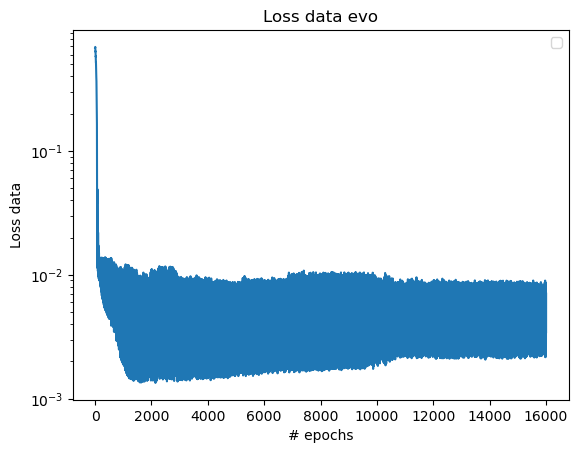

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


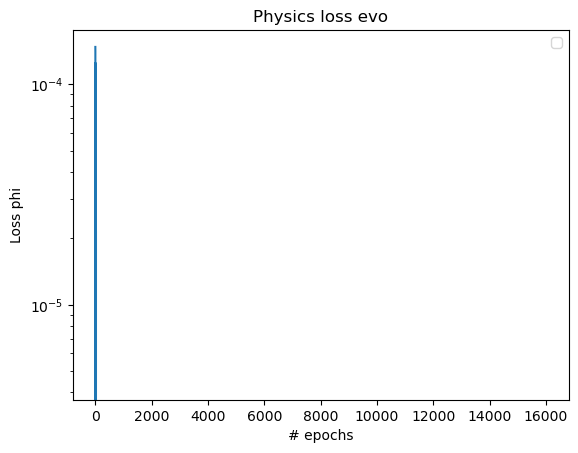

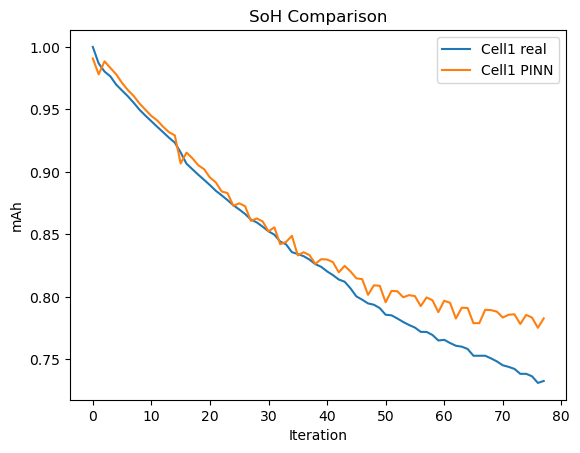

In [50]:
#print MAE e RMSE

# plot comparazione SoH Cell1 - prediction and real su test set

best_net = Net1()
best_net.load_state_dict(torch.load('best_model.pth'))

x=np.arange(100) # n iteration
XCell1, YCell1 = get_data(test_set)
Ynet = best_net(torch.tensor(XCell1).float()).detach().numpy().flatten()

# mae e rmse
mae = np.abs(np.subtract(YCell1,Ynet)).mean() *100
rmse =  math.sqrt(np.square(np.subtract(YCell1,Ynet)).mean() ) *100


print('MAE = ',mae,"%;  RMSE = ", rmse, "%")


# print losses evolutions
fig, ax = plt.subplots()
ax.semilogy(data_loss_evolution)
ax.set(title="Loss data evo", xlabel="# epochs", ylabel="Loss data")
ax.legend()

plt.show()

fig, ax = plt.subplots()
ax.semilogy(physics_loss_evolution)
ax.set(title="Physics loss evo", xlabel="# epochs", ylabel="Loss phi")
ax.legend()

plt.show()


# plot comparazione SoH Cell1 - prediction and real
x=np.arange(100) # n iteration
XCell1, YCell1 = get_data(dataset["Cell1"])
Ynet = best_net(torch.tensor(XCell1).float()).detach().numpy().flatten()

fig, ax = plt.subplots()
ax.plot(x[ : len(YCell1)], YCell1, label="Cell1 real" )
ax.plot(x[ : len(Ynet)], Ynet, label="Cell1 PINN" )
ax.set(title="SoH Comparison", xlabel="Iteration", ylabel="mAh")
ax.legend()

plt.show()
